# Introduction to NLP Fundementals in TensorFlow
Deriving information out of natural language (sequences text or speech).

Another common term for NLP problems is sequence to sequence problems (seq2seq)

In [2]:
import tensorflow as tf

import sys
sys.path.append("../helper")
from helperFunctions import walk_through_dir, plot_loss_curves, \
    create_tensorboard_callback, compare_historys

## Get a text dataset

The set to be used will be from Kaggle's [Introduction to NLP dataset](https://www.kaggle.com/c/nlp-getting-started)

## Visualize the dataset

In [3]:
import pandas as pd
train_df = pd.read_csv("./nlp_kaggle/train.csv")
test_df = pd.read_csv("./nlp_kaggle/test.csv")

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [5]:
# What does the test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
# How many examples of each class are there?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [7]:
len(train_df), len(test_df)

(7613, 3263)

In [8]:
# Visualize random training examples
import random
random_index = random.randint(0, len(train_df)-5)

for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}", "(real disaster)" if target > 0 else "(not are real disaster)")
    print(f"Text:\n{text}\n")
    print("---\n")

Target: 1 (real disaster)
Text:
Kach was a group to which belonged Baruch Goldstein a mass murderer who in 1994 shot and killed 29 PalestinianÛ_ http://t.co/bXGNQ57xvb

---

Target: 1 (real disaster)
Text:
Rly tragedy in MP: Some live to recount horror: ÛÏWhen I saw coaches of my train plunging into water I called ... http://t.co/CaR5QEUVHH

---

Target: 1 (real disaster)
Text:
Criminals Who Hijack Lorries And Buses Arrested In Enugu (PHOTO) http://t.co/LRTU8Rwn2f

---

Target: 0 (not are real disaster)
Text:
@Jannet2208 I fell off someone's back and hit my head on concrete /: I was bleeding n shit

---

Target: 1 (real disaster)
Text:
#breaking #LA Refugio oil spill may have been costlier bigger than projected http://t.co/5ueCmcv2Pk

---



### Split the data into training and validation sets

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# split the data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                        train_df_shuffled["target"].to_numpy(),
                                                        test_size=0.1,
                                                        random_state=42)

In [11]:
# Check the split data
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [12]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Converting text into numbers
When dealing with a text problem, one of the first things that has to be done is to convert text to numbers. This is done by:
- Tokenization: direct mapping of token (word or character) to a number
- Embedding: create a matrix of feature vector for each token (can be definited by the patterns the model learns)

In [13]:
import tensorflow as tf 
# Importing it directly from keras to use Pylance till 2.9.0 is released
from keras.layers import TextVectorization

# The default parameters will be used
text_vectorizer = TextVectorization(max_tokens=None, # How many words in vocab (None=auto, if out of range when definited, replaced by OOV)
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # Create groups of n-words
                                    output_mode="int", # How to map tokens to numbers
                                    output_sequence_length=None) # How long the sequence of words can be
                                    #pad_to_max_tokens=True) # Padds shorter sentences to match the longest and doesn't work if max_token isn't defined

In [14]:
len(train_sentences[0].split())

7

In [15]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [16]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words in vocabulary
max_length = 15 # max length of sequences (how many words from a tweet a model considers)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [17]:
# Fit the text vectorizer
text_vectorizer.adapt(train_sentences)

In [18]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

In [19]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
    \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 @raineishida lol...Im just a nervous wreck :P    

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[9378,    1,   29,    3,    1,  184, 1188,    0,    0,    0,    0,
           0,    0,    0,    0]], dtype=int64)>

In [20]:
# Get the unique words in the vocabulary
words_in_vocabs = text_vectorizer.get_vocabulary() # get all unique words in vocabulary
top_5_words = words_in_vocabs[:5] # most commond words 
bottom_5_words = words_in_vocabs[-5:] # least common words
print(f"Number of words in vocab: {len(words_in_vocabs)}")
print(f"5 most common words in vocab: {top_5_words}")
print(f"5 least common words in vocab: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words in vocab: ['', '[UNK]', 'the', 'a', 'in']
5 least common words in vocab: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer
The most important parameters for tensorflow's embedding layer are:
- input_dim = size of the vocab
- output_dim = size of the output embedding vector (e.g 100 means a token gets represented by a vector of 100 long)
- input_length = length of the sequences being passed to the embedding layer 

In [21]:
from keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # output shape (div by 8 good practice
                             input_length=max_length, # how long is each input
                             embeddings_initializer="uniform")

embedding

In [22]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
    \n\nEmbedded Version:")
    
# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
I'm an emotional wreck watching emmerdale    

Embedded Version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04717222,  0.03611494, -0.03517788, ..., -0.01058657,
         -0.04965016, -0.01800474],
        [-0.01166447, -0.01678411, -0.00245087, ...,  0.04899785,
         -0.00505427, -0.03519667],
        [ 0.01490821, -0.0095902 , -0.00221124, ...,  0.01198392,
         -0.03278033,  0.03485202],
        ...,
        [-0.0170413 , -0.01058949, -0.01751357, ..., -0.03889031,
          0.01332642, -0.02325284],
        [-0.0170413 , -0.01058949, -0.01751357, ..., -0.03889031,
          0.01332642, -0.02325284],
        [-0.0170413 , -0.01058949, -0.01751357, ..., -0.03889031,
          0.01332642, -0.02325284]]], dtype=float32)>

In [23]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.04717222,  0.03611494, -0.03517788, -0.04506956, -0.04982939,
        -0.02777365,  0.04239173, -0.04537418,  0.00347024,  0.03425818,
        -0.01657642,  0.0094107 ,  0.00512083,  0.03208593, -0.02469903,
         0.01054115,  0.01845027, -0.04077818,  0.01801801,  0.03424393,
         0.04986454,  0.04511473,  0.02904605, -0.03358823,  0.00678096,
         0.03641236,  0.02851402, -0.00702752,  0.04305789,  0.02803303,
         0.0372803 , -0.02223498, -0.04750078, -0.01237298, -0.01870228,
         0.03152995,  0.04435673,  0.03405147, -0.0492523 ,  0.02134592,
         0.03138138,  0.03987822,  0.02244799, -0.01945461, -0.0203233 ,
        -0.01220961,  0.02792532,  0.03306397,  0.00417261, -0.03423019,
        -0.03441127, -0.01346204, -0.01442308, -0.02032653, -0.03247011,
        -0.02974182,  0.03528476,  0.01148288,  0.00676139,  0.03544768,
        -0.04238475, -0.04148931,  0.02433154, -0.04606751,  0.0257614 ,
  

## Modelling a text dataset (running a series of experiments)

Types of models to be built:
- Model 0: Naive Bayes (baseline), from Sklearn ML map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
- Model 1: Feed-forward neural network (dense model)
- Model 2: LSTM model (RNN)
- Model 3: GRU model (RNN)
- Model 4: Bidirectional-LSTM model (RNN)
- Model 5: 1D Convolutional Neural Network
- Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning)
- Model 7: Same as model 6 with 10% of training data

### Model 0: Baseline
Sklearn's multinomial naive bayes using TF-IDF formula to convert words to numbers
- It is good practice to use non-DL algorithms as a baseline due to their speed

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # Convert words to numbers using tfidf
    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [49]:
# Evaluate the baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"The baseline score is {baseline_score*100:.2f}%")

The baseline score is 79.27%


In [50]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:10]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0], dtype=int64)

### Creating a function to evaluate some model's predictions using accuracy, precision, recall, f1-score

In [51]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    """
    Calculates model accuracy, precision recall and f1 score of a
    binary classification

    Args:
        y_true (List Bool): true labels of model
        y_pred (List Bool): predicted labels of mode
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1-score using "weighted" avg
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1}
    return model_results

In [52]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                    y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 1: A simple dense model

In [28]:
# Create a tensorboard callback (need to create a new one for each model)
from helperFunctions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [29]:
# Build model with the Functional API
from keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string) # Input are 1-dimensional string
x = text_vectorizer(inputs) # Turn the input to numbers
x = embedding(x) # create an embedding of the numberized inputs
# x = layers.GlobalAveragePooling1D()(x) # condense the feature vector for each token
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer want binary outputs so use sigmoid
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [30]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [31]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model 
model_1_history = model_1.fit(x=train_sentences,
                            y=train_labels,
                            epochs=5,
                            validation_data=(val_sentences, val_labels),
                            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20220514-202407
Epoch 1/5
215/215 [==============================] - 4s 7ms/step - loss: 0.6387 - accuracy: 0.6479 - val_loss: 0.5733 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 1s 7ms/step - loss: 0.4678 - accuracy: 0.8323 - val_loss: 0.4726 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.3394 - accuracy: 0.8734 - val_loss: 0.4557 - val_accuracy: 0.7887
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2557 - accuracy: 0.9095 - val_loss: 0.4565 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.1957 - accuracy: 0.9333 - val_loss: 0.4764 - val_accuracy: 0.7900


In [32]:
# Evaluate the model
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4764 - accuracy: 0.7900


[0.47635507583618164, 0.7900262475013733]

In [33]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs.shape

(762, 1)

In [34]:
# Look at the first 10 predictions
model_1_pred_probs[:10]

array([[0.43627816],
       [0.79292643],
       [0.9930657 ],
       [0.06457859],
       [0.2519146 ],
       [0.9704178 ],
       [0.9432973 ],
       [0.98718786],
       [0.9387273 ],
       [0.09305489]], dtype=float32)

In [35]:
# Convert model predictions to label format
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))

# Calculate model_1 results
model_1_results = calculate_results(y_pred= model_1_preds,
                                    y_true=val_labels)
model_1_results

{'accuracy': 79.00262467191601,
 'precision': 0.7955103864713003,
 'recall': 0.7900262467191601,
 'f1': 0.7869273549752186}

In [36]:
# Check if model_1 outperforms the baseline
# Seems like it isn't
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False,  True])

### Visualizing learned embeddings

In [37]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [38]:
# Model 1 sumamry
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [39]:
# Get the weight matrix of the embedding layer (check summary to see embedding name since rerunning changes it)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
embed_weights.shape # same size as vocab size and embedding_dim (output_dim of embedding layer)

(10000, 128)

Use the TensorFlow projector to visualize the learnt embeddings: http://projector.tensorflow.org

TensorFlow has a guide on [embeddings](https://www.tensorflow.org/text/guide/word_embeddings) as well

In [40]:
# Create embedding files (taken from embeddings link)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

## Recurrent Neural Networks (RNN)
RNNs are useful for sequence data.

The premise of the network is to use the representation of a previous input to aid the representation of the next inputs.

### Model 2: LSTM
LSTM = Long short term memory (one of the most popular LSTM cells)

A typical RNN looks like this:
- Input (text) -> Tokenize -> Embedding -> Layers (RNNs/Dense) -> Output (label probability)


In [41]:
from keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64, return_sequences=True)(x) # when stacking RNN cells together return_seq should be true or else it would return a 2D vector instead of 3D
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [42]:
# Compile the model 
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                experiment_name="model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220514-202420
Epoch 1/5
215/215 [==============================] - 7s 17ms/step - loss: 0.3726 - accuracy: 0.8393 - val_loss: 0.4843 - val_accuracy: 0.7612
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2464 - accuracy: 0.9025 - val_loss: 0.5106 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1703 - accuracy: 0.9383 - val_loss: 0.5823 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1277 - accuracy: 0.9514 - val_loss: 0.8161 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0917 - accuracy: 0.9603 - val_loss: 1.0608 - val_accuracy: 0.7559


In [43]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

array([[0.9692406 ],
       [0.55084723],
       [0.99992466],
       [0.00805045],
       [0.00102254],
       [0.9999275 ],
       [0.99280834],
       [0.9999759 ],
       [0.9999765 ],
       [0.1473513 ]], dtype=float32)

In [44]:
# Convert mdoel 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [45]:
# Calculate model 2 results
model_2_results = calculate_results(val_labels, model_2_preds)
model_2_results

{'accuracy': 75.59055118110236,
 'precision': 0.7559359047877431,
 'recall': 0.7559055118110236,
 'f1': 0.7545650097184197}

In [46]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

# Model 3: GRU
Gated Recurrent Unit is another popular and effective RNN model

The GRU cell has similar features as an LSTM cell, but with less parameters

In [47]:
# Build an RNN using the GRU cell
from keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
# Alternative for a more complex model
# x = layers.GRU(64, return_sequences=True)(x) # seq set to true for stacking recurrent layers
# print(x.shape) # You can see the output if seq isn't true
# x = layers.LSTM(64, return_sequences=True)(x)
# x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x)
# x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [48]:
# Get a summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [49]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
            optimizer=tf.keras.optimizers.Adam(),
            metrics=["accuracy"])

# Fit the mode
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(
                                  SAVE_DIR,
                                  "model_3_GRU"
                              )])

Saving TensorBoard log files to: model_logs/model_3_GRU/20220514-202439
Epoch 1/5
215/215 [==============================] - 4s 12ms/step - loss: 0.2172 - accuracy: 0.9089 - val_loss: 0.6813 - val_accuracy: 0.7717
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1022 - accuracy: 0.9658 - val_loss: 0.7736 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0827 - accuracy: 0.9720 - val_loss: 0.8441 - val_accuracy: 0.7638
Epoch 4/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0690 - accuracy: 0.9731 - val_loss: 0.8311 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0530 - accuracy: 0.9765 - val_loss: 1.2330 - val_accuracy: 0.7638


In [50]:
# Make predictions with the GRU model
model_3_pred_probs = model_3.predict(val_sentences)

# Convert model 3 predictions to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

In [51]:
# Calculate model 3 results
model_3_results = calculate_results(val_labels, model_3_preds)
model_3_results

{'accuracy': 76.37795275590551,
 'precision': 0.7639261289761722,
 'recall': 0.7637795275590551,
 'f1': 0.7624822674694383}

In [52]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

# Model_4: Bidirectional RNN
Normal RNNs go from left to right (just like you'd read an English sentence). However, a bidirectional RNN, additionally goes from right to left

In [53]:
# Build a bidirectional RNN in tensorflow
from keras import layers
inputs = layers.Input(shape=(1,), dtype="string", name="input_layer")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x) 
outputs = layers.Dense(1, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs, outputs, name="Bidirectional_RNN")

In [54]:
model_4.summary()

Model: "Bidirectional_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              74496     
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,354,625
Trainable params: 1,354,6

In [55]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(
                                  SAVE_DIR, "model_4_bidirectional"
                              )])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20220514-202453
Epoch 1/5
215/215 [==============================] - 7s 16ms/step - loss: 0.1526 - accuracy: 0.9432 - val_loss: 0.8249 - val_accuracy: 0.7625
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0670 - accuracy: 0.9740 - val_loss: 0.9871 - val_accuracy: 0.7598
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0542 - accuracy: 0.9769 - val_loss: 1.3352 - val_accuracy: 0.7612
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0493 - accuracy: 0.9781 - val_loss: 1.2185 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0443 - accuracy: 0.9780 - val_loss: 1.3122 - val_accuracy: 0.7454


In [56]:
# Predict using the model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:5]

array([[3.3230823e-04],
       [7.8821719e-01],
       [9.9988317e-01],
       [1.0391406e-01],
       [4.4552027e-05]], dtype=float32)

In [57]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

In [58]:
# Evaluate the predictions
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 74.54068241469817,
 'precision': 0.745282272536504,
 'recall': 0.7454068241469817,
 'f1': 0.7440086660503947}

In [59]:
# Model_4 is even worse than model_3!!
model_3_results

{'accuracy': 76.37795275590551,
 'precision': 0.7639261289761722,
 'recall': 0.7637795275590551,
 'f1': 0.7624822674694383}

# Model_5: 1D Convolutional Neural Network
CNNs were made previously, however, it was for 2D images. Text data is 1D.

Conv1D is used in this case for text and it looks like this
```
Inputs (text) -> Tokenization -> Embedding -> Layers (typically Conv1D + pooling) -> Outputs (class probs)
 ```

In [60]:
# Test out the embedding layer, Conv1D and max pooling
from keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # Turn target to embedding
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        activation="relu",
                        padding="valid")
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalMaxPooling1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to "get most important feature/highest value"

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

- For conv layers:

Difference between same padding and valid padding: https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t

In [61]:
# Build a 1D Conv model
from keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string, name="input_layer")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, # Written in same order as in the function
                 kernel_size=5,
                 strides=1,
                 padding="same", # Keeps all the info and adds 0 paddings
                 activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

In [62]:
# Compile the Conv1D
model_5.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data = (val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(
                                  SAVE_DIR, "Conv1D"
                              )])

Saving TensorBoard log files to: model_logs/Conv1D/20220514-202513
Epoch 1/5
215/215 [==============================] - 3s 9ms/step - loss: 0.1403 - accuracy: 0.9647 - val_loss: 0.8414 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0672 - accuracy: 0.9756 - val_loss: 0.9243 - val_accuracy: 0.7638
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0545 - accuracy: 0.9771 - val_loss: 1.1018 - val_accuracy: 0.7572
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0524 - accuracy: 0.9790 - val_loss: 1.0702 - val_accuracy: 0.7480
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0505 - accuracy: 0.9796 - val_loss: 1.1157 - val_accuracy: 0.7480


In [63]:
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 64)            41024     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 1)              

In [64]:
# Make some predictions with Conv1D
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:5]

array([[7.4400939e-02],
       [9.0064991e-01],
       [9.9969137e-01],
       [3.6925960e-02],
       [8.6281580e-06]], dtype=float32)

In [65]:
# Convert model 5 to labels and evaluate
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 74.80314960629921,
 'precision': 0.7475602233434432,
 'recall': 0.7480314960629921,
 'f1': 0.7472754780275664}

In [66]:
model_4_results

{'accuracy': 74.54068241469817,
 'precision': 0.745282272536504,
 'recall': 0.7454068241469817,
 'f1': 0.7440086660503947}

# Model_6: Transfer Learning
There are different types of models for NLP
- Hugging face trasnformers
- Universal Sentence Encoder
- Other models on the tfhub

In [67]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,"This is a test sentence"])
print(embed_samples[0][:20])

tf.Tensor(
[-0.01157027  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680985  0.05589838 -0.01068729 -0.00597292  0.00639323 -0.0181952
  0.00030814  0.09105888  0.05874645 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865346], shape=(20,), dtype=float32)


In [68]:
embed_samples[0].shape

TensorShape([512])

In [69]:
# Create a Keras Layer using the USE pretrained model
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [70]:
# Create a model using the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_6_USE")

# Compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_6 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [71]:
# Fit the reinforced model
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(
                                  SAVE_DIR, "tf_hub_sentence_encoder"
                              )])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20220514-202538
Epoch 1/5
215/215 [==============================] - 7s 20ms/step - loss: 0.5047 - accuracy: 0.7821 - val_loss: 0.4615 - val_accuracy: 0.7913
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4139 - accuracy: 0.8168 - val_loss: 0.4401 - val_accuracy: 0.8110
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4005 - accuracy: 0.8213 - val_loss: 0.4348 - val_accuracy: 0.8071
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3912 - accuracy: 0.8297 - val_loss: 0.4279 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3849 - accuracy: 0.8298 - val_loss: 0.4285 - val_accuracy: 0.8176


In [72]:
# Predict using the model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:5]

array([[0.17359671],
       [0.73940265],
       [0.9862343 ],
       [0.18700214],
       [0.72474706]], dtype=float32)

In [73]:
# Convert it to labels and evaluate
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.75853018372703,
 'precision': 0.8209627063084894,
 'recall': 0.8175853018372703,
 'f1': 0.8157737537147242}

In [74]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [75]:
len(train_df)

7613

# Model_7: TF Pretrained USE but using 10% of the training data

- When you uncomment the other 10% data in the below cell.

Model 7 is doing better than model 6 despite having 10% of the data!!

Something seems off.
Looking back the 10% data was made off of the whole dataset. 

Yes, both times while splitting the whole dataset and taking 10% of it was done randomly, there seems to be some data leakage (val sentence in training)

DO NOT MAKE DATA SPLITS WHICH LEAK DATA FROM VALIDATION/TEST SETS INTO TRAIN SETS

In [76]:
# # Create a 10% data subset
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# # train_10_percent.head(), len(train_10_percent)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [77]:
# Check the number of targets in the subset data
# train_10_percent["target"].value_counts()

In [78]:
# train_df_shuffled["target"].value_counts()

In [79]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [80]:
# Check the number of each label in the updated training data subset
# Imbalanced ratio but workable
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

### Recreate the model same as the previous one

In [81]:
# Build the same model
# model_7 = tf.keras.models.clone_model(model_6)
model_7 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid", name="output_layer")
], name="model_7_USE") # Copied to change the name

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])

model_7.summary()

Model: "model_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [82]:
# Fit the model to the 10% data subset
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(
                                  SAVE_DIR, "tf_hub_sentence_encoder_10_percent"
                              )])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder_10_percent/20220514-202600
Epoch 1/5
22/22 [==============================] - 2s 61ms/step - loss: 0.6766 - accuracy: 0.6628 - val_loss: 0.6524 - val_accuracy: 0.7283
Epoch 2/5
22/22 [==============================] - 1s 38ms/step - loss: 0.6100 - accuracy: 0.8044 - val_loss: 0.5976 - val_accuracy: 0.7638
Epoch 3/5
22/22 [==============================] - 1s 36ms/step - loss: 0.5352 - accuracy: 0.8146 - val_loss: 0.5430 - val_accuracy: 0.7861
Epoch 4/5
22/22 [==============================] - 1s 36ms/step - loss: 0.4727 - accuracy: 0.8161 - val_loss: 0.5093 - val_accuracy: 0.7690
Epoch 5/5
22/22 [==============================] - 1s 37ms/step - loss: 0.4282 - accuracy: 0.8234 - val_loss: 0.4913 - val_accuracy: 0.7769


In [83]:
# Make predictions with the model
model_7_pred_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:6]

<tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1.], dtype=float32)>

In [84]:
# Evaluate model 7
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.69028871391076,
 'precision': 0.7779652793701148,
 'recall': 0.7769028871391076,
 'f1': 0.7752416323647977}

In [85]:
model_6_results

{'accuracy': 81.75853018372703,
 'precision': 0.8209627063084894,
 'recall': 0.8175853018372703,
 'f1': 0.8157737537147242}

These results make sense now. Still, with only 10% of the data the prediction is pretty good

In [86]:
# Comparing the performance of eac model

In [88]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                "1_simple_dense": model_1_results,
                                "2_lstm": model_2_results,
                                "3_gru": model_3_results,
                                "4_bidirectional": model_4_results,
                                "5_con1d": model_5_results,
                                "6_tf_hub_use_encoder": model_6_results,
                                "6_tf_hub_use_encoder": model_6_results,
                                "7_tf_hub_encoder": model_7_results})
all_model_results = all_model_results.transpose()

In [89]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100


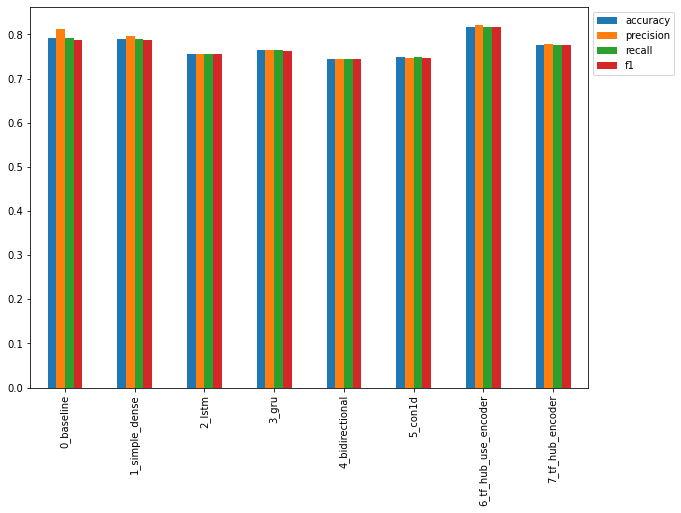

In [90]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

<AxesSubplot:>

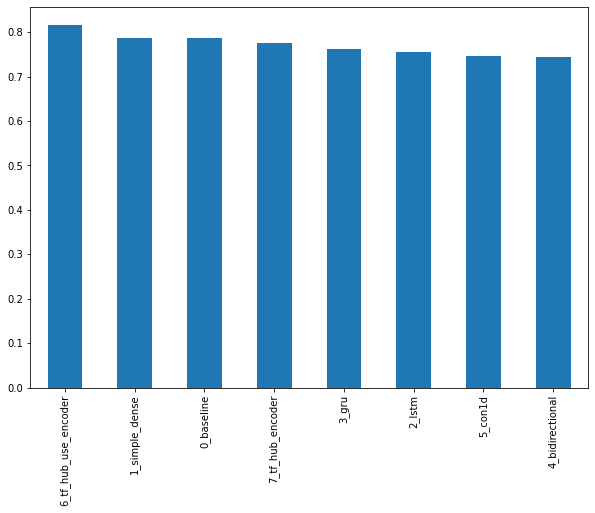

In [91]:
# Sort model results by f1_score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", \
    figsize=(10,7))

# Upload the model training logs to TensorBoard

In [ ]:
!tensorboard dev upload --logdir ./model_logs/ \
    --name "NLP Modelling Experiments" \
    --description "Comparing different model architectures on Kaggle's tweet text classification data set" \
    --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/hkNc5NubTLWFX575YSeVwA/

[2022-05-14T20:12:18] Started scanning logdir.
Data upload starting...
Uploading binary object (68.8 kB)...
Uploading binary object (61.6 kB)...
Uploading binary object (61.3 kB)...
Uploading binary object (61.3 kB)...
Uploading binary object (397.9 kB)...
Uploading binary object (233.9 kB)...
Uploading binary object (422.0 kB)...
Uploading binary object (904.8 kB)...
Uploading binary object (904.8 kB)...
Uploading binary object (905.1 kB)...
Uploading binary object (905.1 kB)...
Uploading 330 scalars...
[2022-05-14T20:12:31] Total uploaded: 330 scalars, 0 tensors, 11 binary objects (4.8 MB)
[2022-05-14T20:12:31] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/hkNc5NubTLWFX575YSeVwA/


# Saving and loading a trained model
The two main models of saving a model in tensorflow
1. HDF5 format
2. SavedModel format

In [92]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("/saved_models/model_6.h5")

In [ ]:
# Load model with custom 
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("/saved_models/model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
# How does the loaded model perform
loaded_model_6.evaluate(val_sentences, val_labels)

In [ ]:
# Save the model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [ ]:
# Load model 
loaded_model_6_SavedModel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [ ]:
# Evaluate model in SavedModel format
loaded_model_6_SavedModel_format.evaluate(val_sentences, val_labels)

# Finding the most wrong examples

For example if a sample should have a label of 0 and predicts 0.99 and vice versa (model-driven data exploration)

In [1]:
import tensorflow as tf

In [27]:
# Load the universal model
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)


24/24 [==============================] - 2s 16ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [29]:
# Make predictions with the loaded model form globals
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [32]:
# Create DataFrame with validation sentences and best performing model prediction labels + probs
val_df = pd.DataFrame({"text": val_sentences,
                    "target": val_labels,
                    "pred": model_6_pretrained_preds,
                    "pred_probs": tf.squeeze(model_6_pretrained_pred_probs)})
val_df[:10]


,text,target,pred,pred_probs
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808
5,Investigators rule catastrophic structural fai...,1,1.0,0.709675
6,How the West was burned: Thousands of wildfire...,1,1.0,0.981907
7,Map: Typhoon Soudelor's predicted path as it a...,1,1.0,0.981066
8,Ûª93 blasts accused Yeda Yakub dies in Karach...,1,1.0,0.945744
9,My ears are bleeding https://t.co/k5KnNwugwT,0,0.0,0.085040


In [35]:
df_wrong = val_df[val_df["pred"]!=val_df["target"]].sort_values("pred_probs", ascending=False)
df_wrong.head() # False positives

,text,target,pred,pred_probs
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213


In [36]:
df_wrong.tail() # False negatives

,text,target,pred,pred_probs
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


The target labels:
- 0 = not disaster
- 1 = disaster

In [39]:
# Check the false positives (model predicted 1 when should've been 0)
for row in df_wrong[:10].itertuples():
    _, text, target, pred, pred_probs = row
    print(f"Target: {target}, Pred: {pred}, Prob: {pred_probs}")
    print(f"Text:\n{text}\n")
    print("---\n")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

---

Target: 0, Pred: 1.0, Prob: 0.8769820928573608
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

---

Target: 0, Pred: 1.0, Prob: 0.8523000478744507
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

---

Target: 0, Pred: 1.0, Prob: 0.8354543447494507
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

---

Target: 0, Pred: 1.0, Prob: 0.8272132873535156
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

---

Target: 0, Pred: 1.0, Prob: 0.8148158192634583
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

---

Tar

In [41]:
# Check the false positives (model predicted 1 when should've been 0)
for row in df_wrong[-10:].itertuples():
    _, text, target, pred, pred_probs = row
    print(f"Target: {target}, Pred: {pred}, Prob: {pred_probs}")
    print(f"Text:\n{text}\n")
    print("---\n")

Target: 1, Pred: 0.0, Prob: 0.06730346381664276
Text:
@DavidVonderhaar At least you were sincere ??

---

Target: 1, Pred: 0.0, Prob: 0.05507579818367958
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

---

Target: 1, Pred: 0.0, Prob: 0.05460337549448013
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

---

Target: 1, Pred: 0.0, Prob: 0.05459696426987648
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

---

Target: 1, Pred: 0.0, Prob: 0.049637261778116226
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

---

Target: 1, Pred: 0.0, Prob: 0.043918490409851074
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

---

Target: 1, Pred: 0.0, Prob: 0.042086

# Predict tweets on the wild
Try using the model on some tweets found online and see if it predicts correctly or not.

# The speed/score tradeoff

In [43]:
# Measure the time of prediction 
import time 
def pred_timer(model, samples):
    """
    Times how long a model takes to make predictions on samples.

    Args:
        model (tf.keras.model): The model that will predict the labels
        samples (List of strings): The samples the model will use
    """
    start_time = time.perf_counter() # get start time
    model.predict(samples) # make predictions
    end_time = time.perf_counter() # get finish time
    total_time = end_time-start_time # calculate how long prediction took
    time_per_pred = total_time/len(samples)
    return total_time, time_per_pred

In [46]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                    samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.4613787999999204, 0.0006054839895012078)

In [58]:
model_6_pretrained_results = calculate_results(val_labels, model_6_pretrained_preds)
model_6_pretrained_results 

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

In [54]:
# Calculate the baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0,
                                                        val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.011641099999906146, 1.527703412061174e-05)

Text(0, 0.5, 'F1-score')

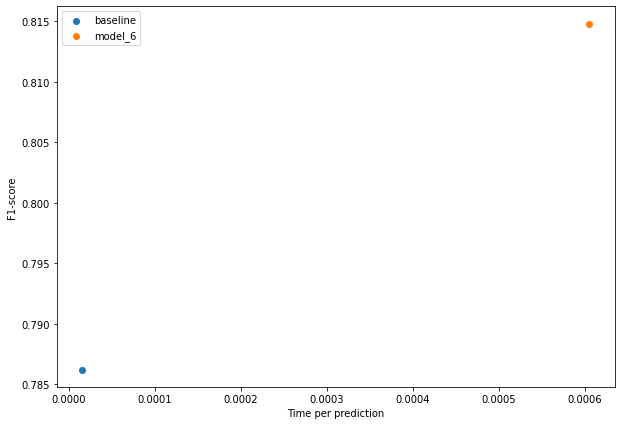

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="model_6")
plt.legend()
plt.xlabel("Time per prediction")
plt.ylabel("F1-score")